In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload

import matplotlib.pyplot as plt
import numpy
import astrohack_projections
#numpy.random.seed(42)

# create one crazy looking Gaussian for the 3D model
#mu = numpy.zeros(3)
#fi = 0
#for i in xrange(3):
#    v = numpy.random.normal(size=3)
#    fi += numpy.outer(v, v)

basevar = 0.5 * numpy.eye(3)

gal_model = astrohack_projections.galaxy_model_3d()
v = [3., 0., 0.]
gal_model.add_gaussian(1.0, numpy.array([0., -1., 0.]), basevar + numpy.outer(v,v))
v = [-1., 3., 0.]
gal_model.add_gaussian(1.0, numpy.array([2., 1., 0.]), basevar + numpy.outer(v,v))
v = [1., 3., 0.]
gal_model.add_gaussian(1.0, numpy.array([-2., 1., 0.]), basevar + numpy.outer(v,v))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


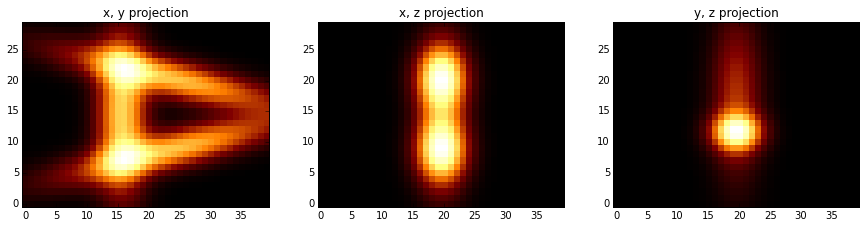

In [28]:
plt.rcParams['figure.figsize'] = 15,5

plot_kwargs = {"interpolation": "nearest",
          "cmap": "afmhot",
          "origin": "lower"}

xs = numpy.linspace(-5, 5, 30)
ys = numpy.linspace(-5, 5, 40)
X, Y = numpy.meshgrid(xs, ys)

# plot the projections
plt.subplot(1, 3, 1)
xi_hat = numpy.array((1, 0, 0))
eta_hat = numpy.array((0, 1, 0))
densities = gal_model.render_2d_image(xi_hat, eta_hat, xs, ys)
plt.imshow(densities, **plot_kwargs)
plt.title("x, y projection")

plt.subplot(1, 3, 2)
xi_hat = numpy.array((1, 0, 0))
eta_hat = numpy.array((0, 0, 1))
densities = gal_model.render_2d_image(xi_hat, eta_hat, xs, ys)
plt.imshow(densities, **plot_kwargs)
plt.title("x, z projection")

plt.subplot(1, 3, 3)
xi_hat = numpy.array((0, 1, 0))
eta_hat = numpy.array((0, 0, 1))
densities = gal_model.render_2d_image(xi_hat, eta_hat, xs, ys)
plt.imshow(densities, **plot_kwargs)
plt.title("y, z projection")

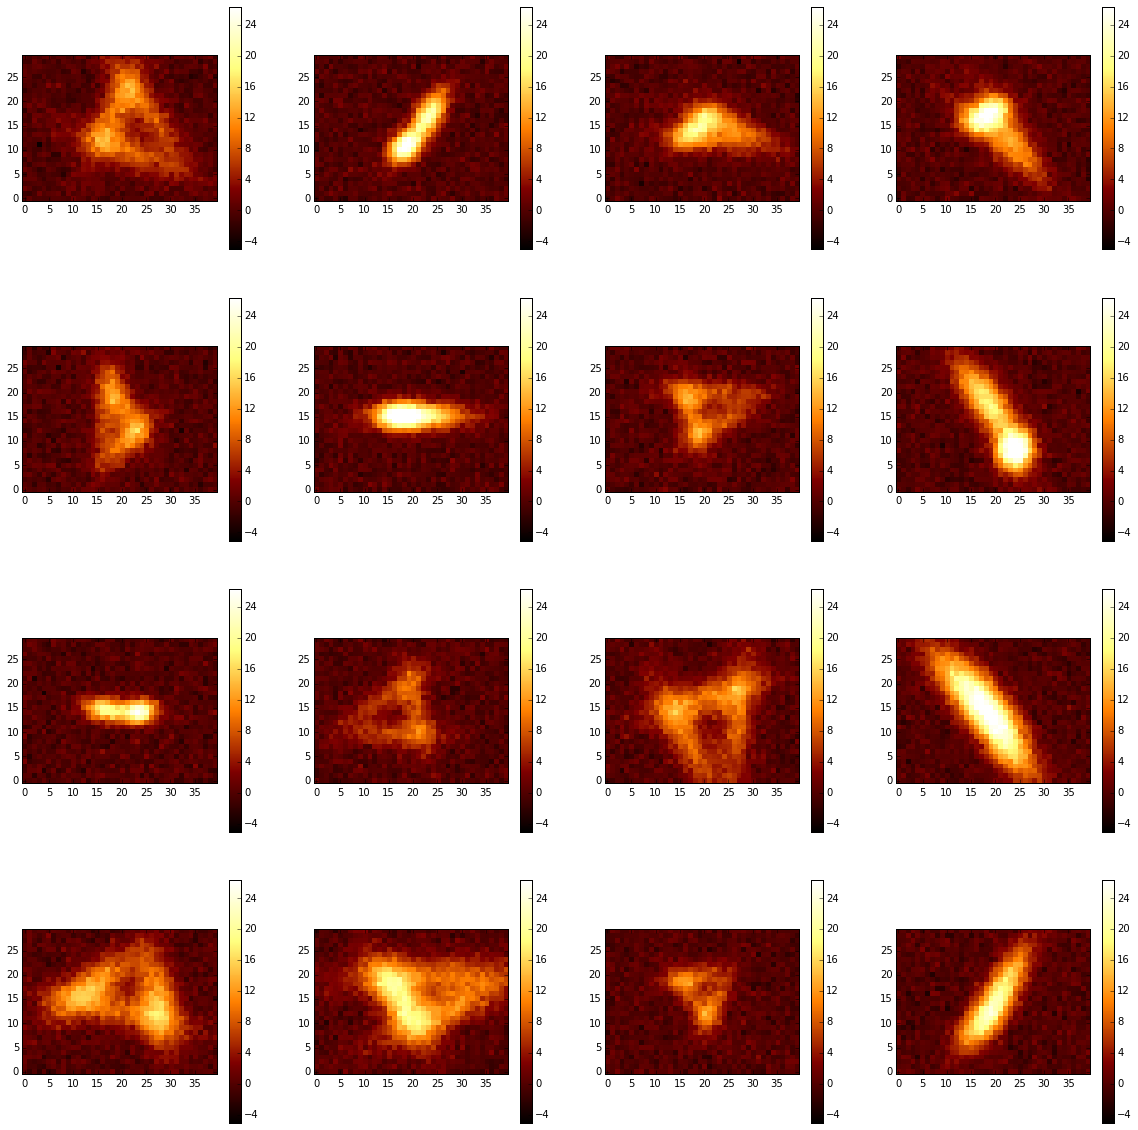

In [29]:
# randomise 16 different projections and create noisy images of these projections
# randomise all the parameters that are needed for that

plt.rcParams['figure.figsize'] = 20, 20

album = astrohack_projections.album_and_model()
psf = astrohack_projections.mixture_of_gaussians(2)
psf.add_gaussian(1., numpy.array([0., 0.]), numpy.eye(2)*1.)

vmin = None

for i in xrange(16):
    image = astrohack_projections.image_and_model()
    alpha, beta, gamma = numpy.random.uniform(0.0, 360.0, size=3)
    intensity = numpy.random.uniform(100.0, 150.0)
    scale = 0.25 * numpy.exp(numpy.random.uniform())
    xshift = numpy.random.uniform(13., 16.)
    yshift = numpy.random.uniform(18., 21.)

    image = astrohack_projections.image_and_model()
    image.set_shape((30, 40))
    image.set_psf(psf)
    kwargs = {'alpha':alpha, 'beta':beta, 'gamma':gamma, 'intensity':intensity, 'scale':scale, 'xshift': xshift, 'yshift': yshift, 'bg':0.0}
    image.set_parameters(**kwargs)
    image.set_galaxy(gal_model)
    image.set_ivar(numpy.ones(image.get_shape()))
    image.construct_synthetic()
    image.set_data(image.get_synthetic() + numpy.random.normal(size=image.get_shape()) / numpy.sqrt(image.ivar))

    # save to album
    album.add_image(image)

    # plot
    if vmin is None:
        a, mid = numpy.percentile(image.get_data(), [25., 50.])
        ran = mid - a
        vmin = mid - 5. * ran
        vmax = mid + 20. * ran

    plt.subplot(4, 4, i+1)
    plt.imshow(image.get_data(), vmin=vmin, vmax=vmax, **plot_kwargs)
    plt.colorbar()

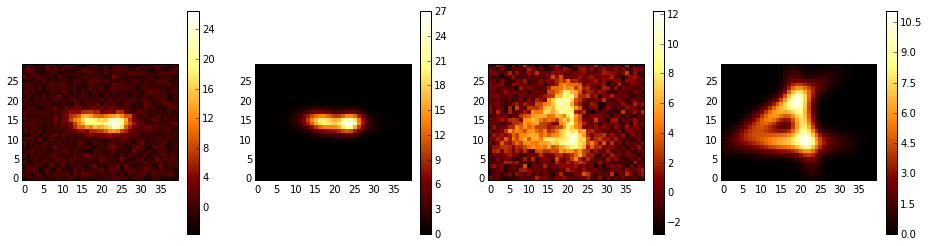

In [30]:
plt.rcParams['figure.figsize'] = 20, 40

def showme(album, vmin, vmax):
    for i in xrange(len(album)):
        image = album.get_all_images()[i]
        plt.subplot(8, 4, 2*i+1)
        plt.imshow(image.get_data(), vmin=vmin, vmax=vmax, **plot_kwargs)
        plt.colorbar()
        plt.subplot(8, 4, 2*i+2)
        plt.imshow(image.get_synthetic(), vmin=vmin, vmax=vmax, **plot_kwargs)
        plt.colorbar()
#showme(album, vmin, vmax)

def showme_small(album, v=False):
    plt.rcParams['figure.figsize'] = 16, 4
    plot_kwargs = {"interpolation": "nearest",
          "cmap": "afmhot",
          "origin": "lower"}
    for j, i in enumerate([8, 9]):
        image = album.get_all_images()[i]
        plt.subplot(1, 4, 2*j+1)
        vmin = -5. / numpy.sqrt(numpy.median(image.get_ivar())) # assumes bg = 0
        vmax = -2. * vmin # assumes bg = 0
        if v==True:
            vmin = None
            vmax = None
        plt.imshow(image.get_data(), vmin=vmin, vmax=vmax, **plot_kwargs)
        plt.colorbar()
        plt.subplot(1, 4, 2*j+2)
        plt.imshow(image.get_synthetic(), vmin=vmin, vmax=vmax, **plot_kwargs)
        plt.colorbar()  

#showme(album)
showme_small(album, v=True)
plt.savefig("/Users/dalyabaron/Copy/Astrophysics/python/new_scripts/new_scripts/DeprojectAllGalaxies/fitting_pngs/phase2_synthetic.png")

/Users/dalyabaron/.virtualenvs/astro/lib/python2.7/site-packages/scipy/optimize/optimize.py:1778: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/dalyabaron/.virtualenvs/astro/lib/python2.7/site-packages/scipy/optimize/optimize.py:1779: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


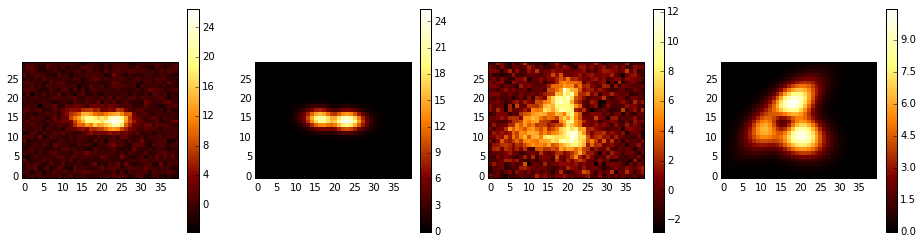

In [33]:
import scipy.optimize as op

par0 = numpy.array([1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
                    1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
                    1., 0., 0., 1., 1., 1., 1., 0., 0., 0.])

album(par0)
#showme_small(album, v=True)
#plt.savefig("/Users/dalyabaron/Copy/Astrophysics/python/new_scripts/new_scripts/DeprojectAllGalaxies/fitting_pngs/phase2_init.png")

result = op.minimize(album, par0, method="Powell")
par = result["x"]
album(par)
showme_small(album, v=True)
plt.savefig("/Users/dalyabaron/Copy/Astrophysics/python/new_scripts/new_scripts/DeprojectAllGalaxies/fitting_pngs/phase2_final.png")
#print "the initial guess: ", str(par0)
#print "the final parameters: ", str(par)

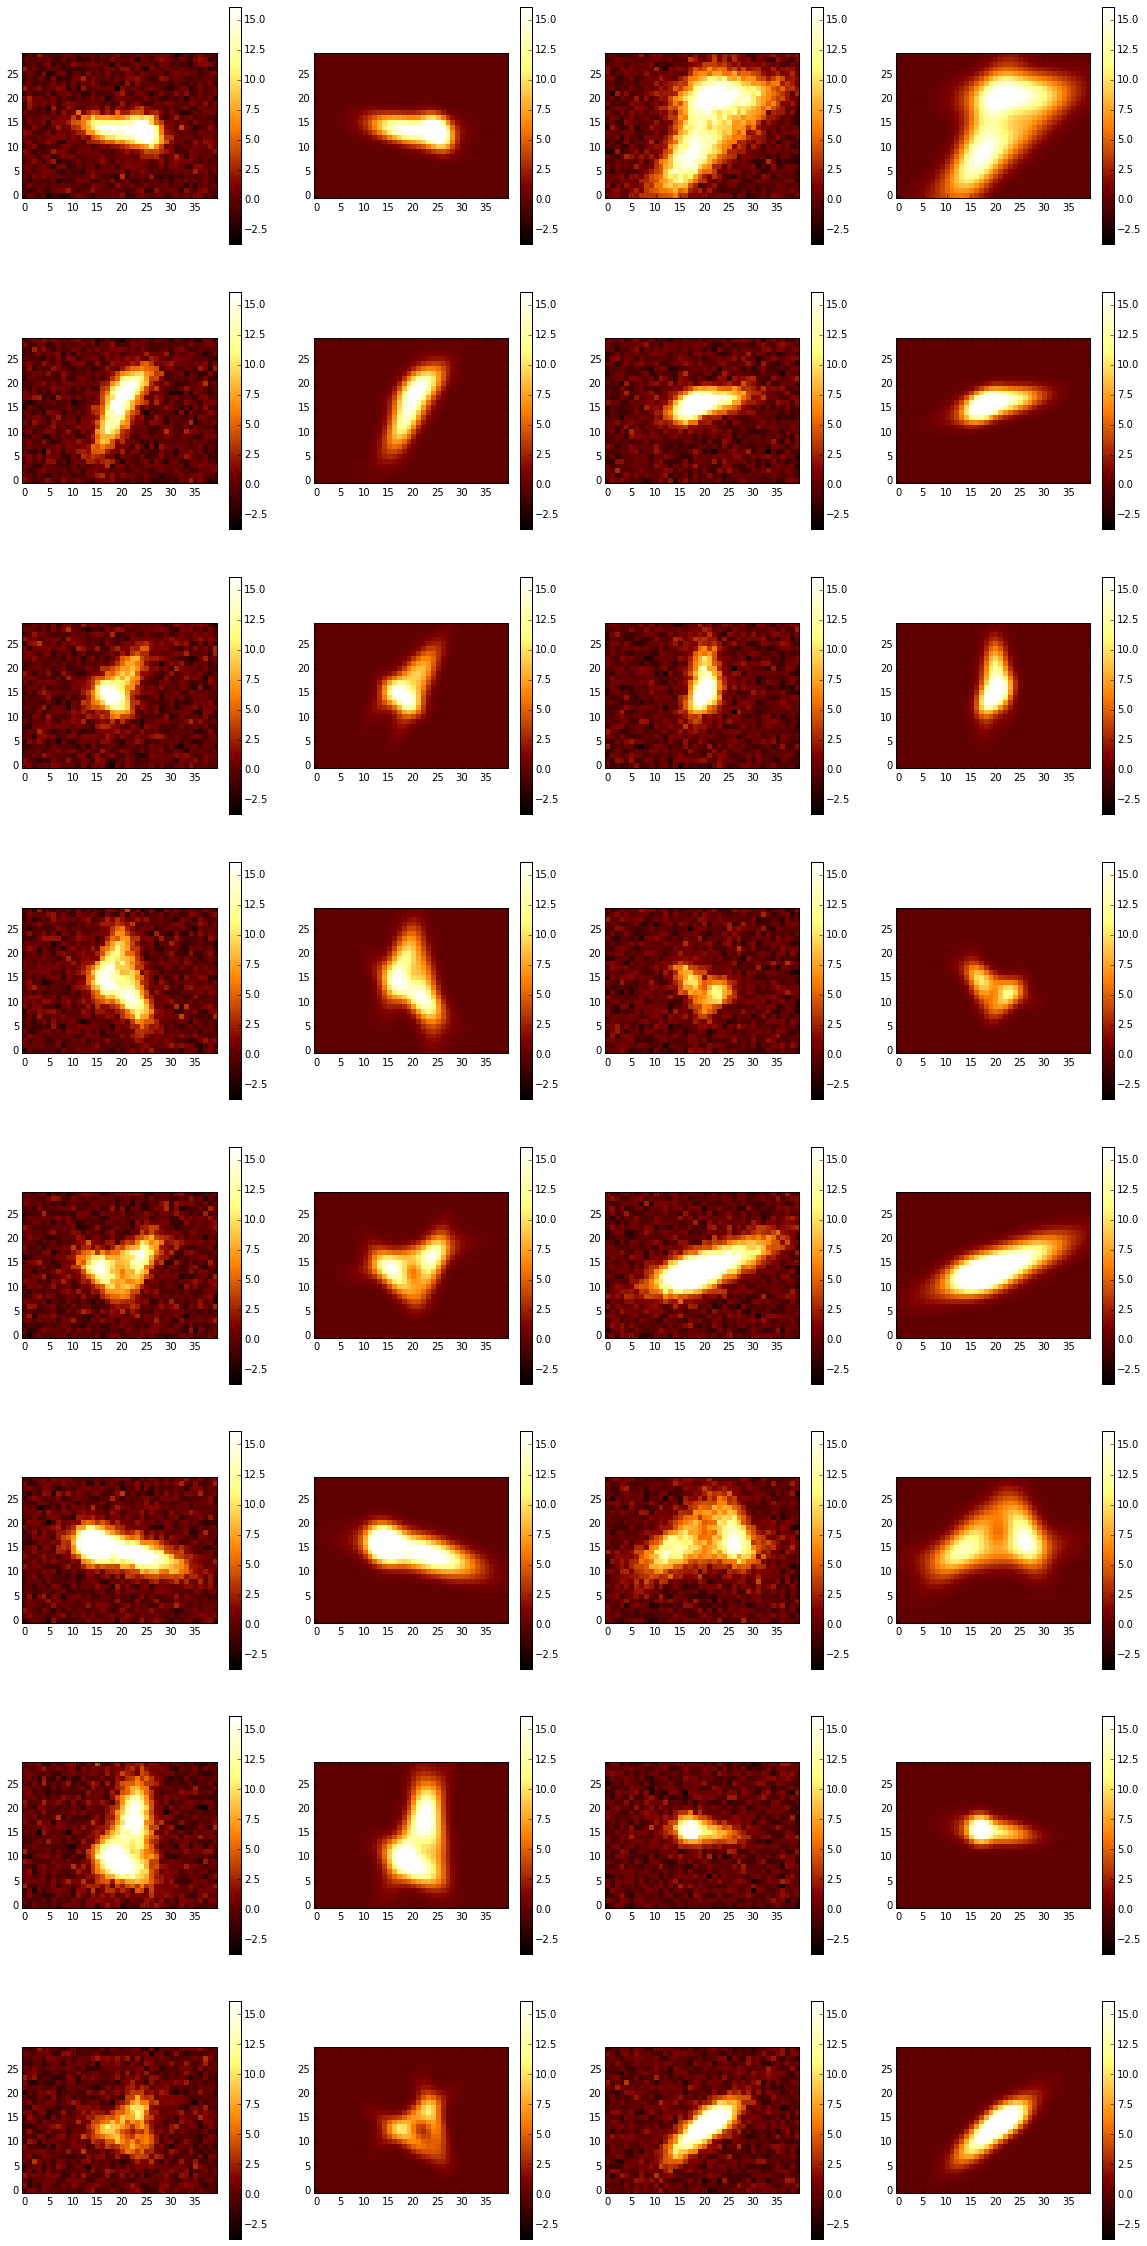

In [26]:
plt.rcParams['figure.figsize'] = 20, 40
showme(album, vmin, vmax)

In [11]:
print album.get_ln_prior()
print album.get_ln_likelihood()

-3.99625091966
-9506.31759574


In [ ]:
# test how well are we doing for more than one run

for i in xrange(30):
    
    # build the galaxy model
    mu = numpy.zeros(3)
    fi = 0
    for i in xrange(3):
        v = numpy.random.normal(size=3)
        fi += numpy.outer(v, v)

    gal_model = astrohack_projections.galaxy_model_3d()
    gal_model.add_gaussian(1.0, mu, fi) 
    pars_initial = numpy.array([1.0, mu[0]])